In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam

import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt

In [2]:
path = 'c:/Users/admin/Documents/Datasets/ETHEC_dataset_butterfly/'

train_images = tf.keras.utils.image_dataset_from_directory(path, image_size=(512, 512), batch_size=16)

Found 46347 files belonging to 1 classes.


In [3]:
train_images

<BatchDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [4]:
for x, y in train_images.take(1):
    print(x.shape)

(16, 512, 512, 3)


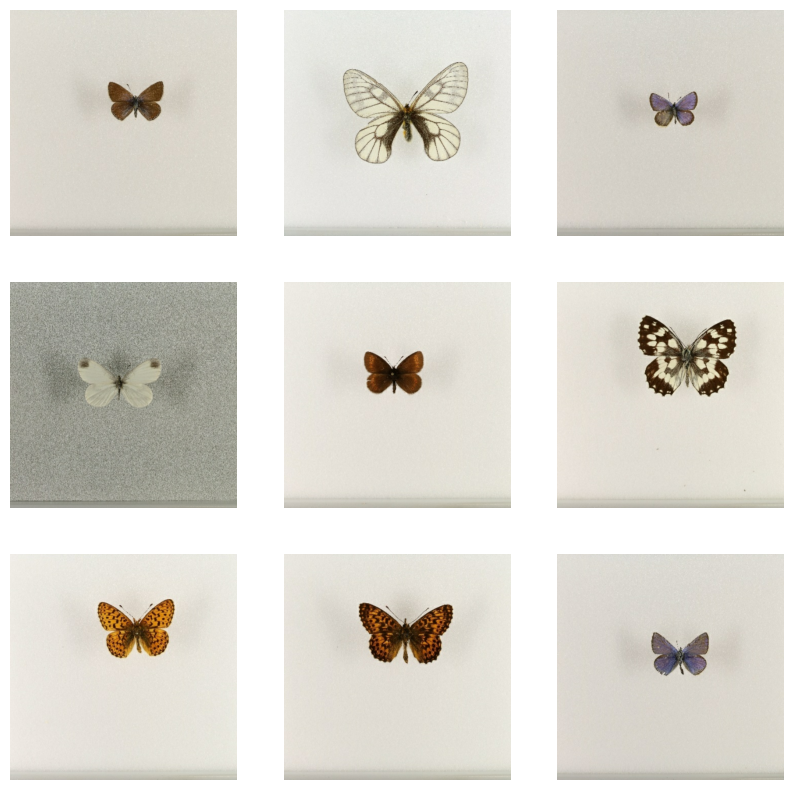

In [5]:
plt.figure(figsize=(10, 10))
for images, labels in train_images.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

In [6]:
normalization_layer = layers.Rescaling(1./255)
normalized_train_images = train_images.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_train_images))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0053308825 0.99117655


In [7]:
image_shape = (512, 512, 3)
batch_size = 16

In [8]:
class WGAN_GP():
    def __init__(self, input_shape):

        self.z_dim = 64
        self.input_shape = input_shape

        self.loss_critic = {}
        self.loss_gp = {}
        self.loss_generator = {}
        
        # critic
        self.n_critic = 5
        self.penalty_const = 10
        self.critic = self.build_critic()
        self.critic.trainable = False

        self.optimizer_critic = Adam(1e-4, 0.5, 0.9)

        # build generator pipeline with frozen critic
        self.generator = self.build_generator()
        critic_output = self.critic(self.generator.output)
        self.model = Model(self.generator.input, critic_output)
        self.model.compile(loss = self.wasserstein_loss,
                           optimizer = Adam(1e-4, 0.5, 0.9))
        self.critic.trainable = True
        
    def wasserstein_loss(self, y_true, y_pred):

        w_loss = -tf.reduce_mean(y_true*y_pred)

        return w_loss

    def build_generator(self):

        DIM = 64
        model = tf.keras.Sequential(name='Generator') 

        model.add(layers.Input(shape=[self.z_dim])) 

        model.add(layers.Dense(16*16*8*DIM))                                                
        model.add(layers.LayerNormalization()) 
        model.add(layers.ReLU())
        model.add(layers.Reshape((16,16,8*DIM)))                                            
        
        model.add(layers.UpSampling2D((2,2), interpolation="bilinear"))               
        model.add(layers.Conv2D(8*DIM, 5, padding='same'))                                
        model.add(layers.LayerNormalization()) 
        model.add(layers.ReLU())
        
        model.add(layers.UpSampling2D((2,2), interpolation="bilinear"))               
        model.add(layers.Conv2D(4*DIM, 5, padding='same'))                                
        model.add(layers.LayerNormalization()) 
        model.add(layers.ReLU())
        
        model.add(layers.UpSampling2D((2,2), interpolation="bilinear"))                    
        model.add(layers.Conv2D(2*DIM, 5, padding='same'))                                 
        model.add(layers.LayerNormalization()) 
        model.add(layers.ReLU())
        
        model.add(layers.UpSampling2D((2,2), interpolation="bilinear"))                 
        model.add(layers.Conv2D(DIM, 5, padding='same'))                              
        model.add(layers.LayerNormalization()) 
        model.add(layers.ReLU())

        model.add(layers.UpSampling2D((2,2), interpolation="bilinear"))                   
        model.add(layers.Conv2D(image_shape[-1], 5, padding='same', activation='tanh'))   

        return model             
    
    def build_critic(self):

        DIM = 64
        model = tf.keras.Sequential(name='critics') 

        model.add(layers.Input(shape=self.input_shape)) 

        model.add(layers.Conv2D(1*DIM, 5, strides=2, padding='same', use_bias=False))    
        model.add(layers.LeakyReLU(0.2))

        model.add(layers.Conv2D(2*DIM, 5, strides=2, padding='same', use_bias=False))
        model.add(layers.LeakyReLU(0.2))

        model.add(layers.Conv2D(4*DIM, 5, strides=2, padding='same', use_bias=False))
        model.add(layers.LeakyReLU(0.2))

        model.add(layers.Conv2D(8*DIM, 5, strides=2, padding='same', use_bias=False))
        model.add(layers.LeakyReLU(0.2))
        
        model.add(layers.Conv2D(16*DIM, 5, strides=2, padding='same', use_bias=False))
        model.add(layers.LeakyReLU(0.2))
        
        model.add(layers.Conv2D(32*DIM, 5, strides=2, padding='same', use_bias=False))
        model.add(layers.LeakyReLU(0.2))
        
        model.add(layers.Conv2D(64*DIM, 5, strides=2, padding='same', use_bias=False))
        model.add(layers.LeakyReLU(0.2))
     
        model.add(layers.Flatten()) 
        model.add(layers.Dense(1)) 

        return model     
    
 
    def gradient_loss(self, grad):

        loss = tf.square(grad)
        loss = tf.reduce_sum(loss, axis=np.arange(1,len(loss.shape)))
        loss = tf.sqrt(loss)
        loss = tf.reduce_mean(tf.square(loss - 1))
        loss = self.penalty_const * loss
        return loss

    def train_critic(self, real_images, batch_size):
        real_labels = tf.ones(batch_size)
        fake_labels = -tf.ones(batch_size)
                  
        g_input = tf.random.normal((batch_size, self.z_dim))
        fake_images = self.generator.predict(g_input, verbose=0)
        
        with tf.GradientTape() as gradient_tape,\
             tf.GradientTape() as total_tape:
            
            # forward pass
            pred_fake = self.critic(fake_images)
            pred_real = self.critic(real_images)
            
            # calculate losses
            loss_fake = self.wasserstein_loss(fake_labels, pred_fake)
            loss_real = self.wasserstein_loss(real_labels, pred_real)           
            
            # gradient penalty      
            epsilon = tf.random.uniform((batch_size,1,1,1))
            interpolates = epsilon*real_images + (1-epsilon)*fake_images
            gradient_tape.watch(interpolates)
            
            critic_interpolates = self.critic(interpolates)
            gradients_interpolates = gradient_tape.gradient(critic_interpolates, [interpolates])
            gradient_penalty = self.gradient_loss(gradients_interpolates)
     
            # total loss
            total_loss = loss_fake + loss_real + gradient_penalty
            
            # apply gradients
            gradients = total_tape.gradient(total_loss, self.critic.trainable_variables)
            
            self.optimizer_critic.apply_gradients(zip(gradients, self.critic.trainable_variables))

        return loss_fake, loss_real, gradient_penalty
                                                
    def train(self, data_generator, batch_size, steps, interval=100):

        val_g_input = tf.random.normal((batch_size, self.z_dim))
        real_labels = tf.ones(batch_size)

        for i in range(steps):
            for _ in range(self.n_critic):
                real_images = data_generator
                loss_fake, loss_real, gradient_penalty = self.train_critic(real_images, batch_size)
                critic_loss = loss_fake + loss_real
            # train generator
            g_input = tf.random.normal((batch_size, self.z_dim))
            g_loss = self.model.train_on_batch(g_input, real_labels)
            self.loss_gp[i] = gradient_penalty
            self.loss_critic[i] = critic_loss.numpy()
            self.loss_generator[i] = g_loss
            if i%interval == 0:
                msg = "Step {}: g_loss {:.4f} critic_loss {:.4f} critic fake {:.4f}  critic_real {:.4f} penalty {:.4f}"\
                .format(i, g_loss, critic_loss, loss_fake, loss_real, gradient_penalty)
                print(msg)

                fake_images = self.generator.predict(val_g_input, verbose=0)
                self.plot_images(fake_images)
                # self.plot_losses()

    def plot_images(self, images):   
        grid_row = 1
        grid_col = 6
        f, axarr = plt.subplots(grid_row, grid_col, figsize=(grid_col*3.5, grid_row*3.5))
        for row in range(grid_row):
            for col in range(grid_col):
                if self.input_shape[-1]==1:
                    axarr[col].imshow(images[col,:,:,0]*0.5+0.5, cmap='gray')
                else:
                    axarr[col].imshow(images[col]*0.5+0.5)
                axarr[col].axis('off') 
        plt.show()

    def plot_losses(self):
        fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True)
        fig.set_figwidth(10)
        fig.set_figheight(6)
        ax1.plot(list(self.loss_critic.values()), label='Critic loss', alpha=0.7)
        ax1.set_title("Critic loss")
        ax2.plot(list(self.loss_generator.values()), label='Generator loss', alpha=0.7)
        ax2.set_title("Generator loss")
        ax3.plot(list(self.loss_gp.values()), label='Gradient penalty', alpha=0.7)
        ax3.set_title("Gradient penalty")
        plt.xlabel('Steps')
        plt.show()

In [9]:
wgan = WGAN_GP(image_shape)

Step 0: g_loss 31.8853 critic_loss -468.1857 critic fake -189.9191  critic_real -278.2667 penalty 516.6873


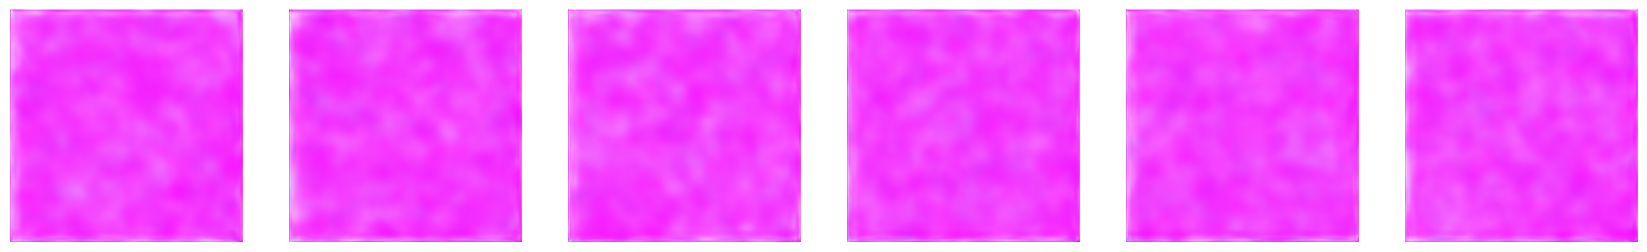

Step 100: g_loss -19.0565 critic_loss -71.7947 critic fake 110.9826  critic_real -182.7773 penalty 39.4277


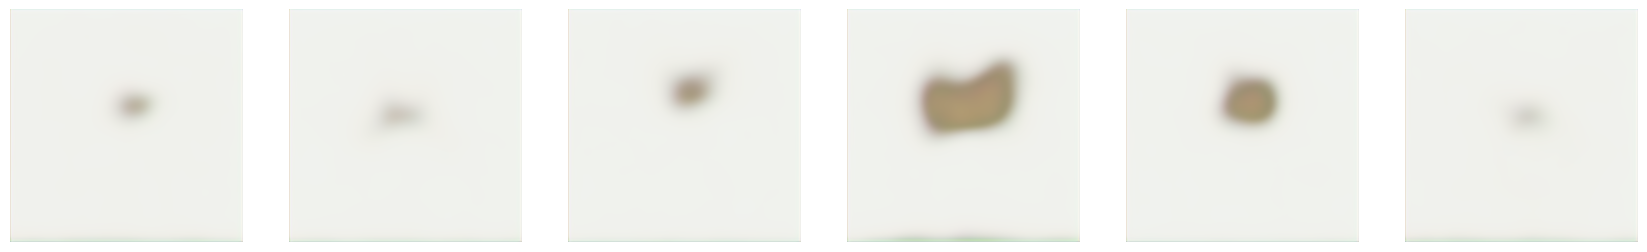

Step 200: g_loss 16.6156 critic_loss -32.7910 critic fake 80.6059  critic_real -113.3970 penalty 7.1681


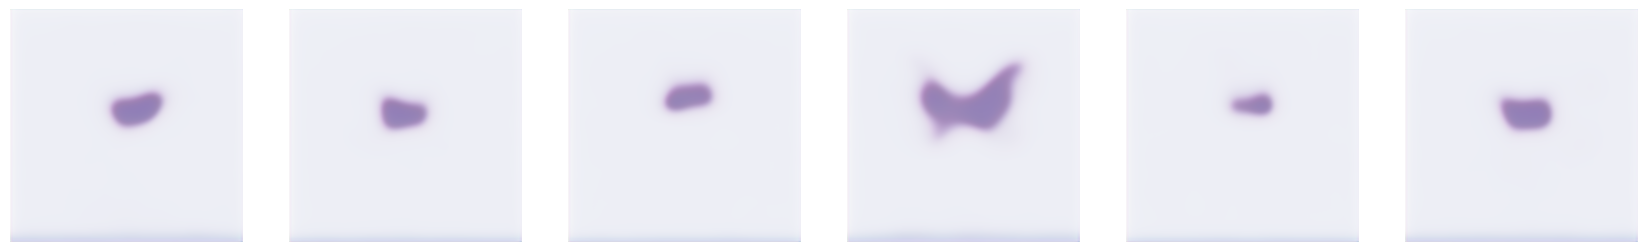

Step 300: g_loss 54.3428 critic_loss -25.7818 critic fake -49.0805  critic_real 23.2987 penalty 2.6655


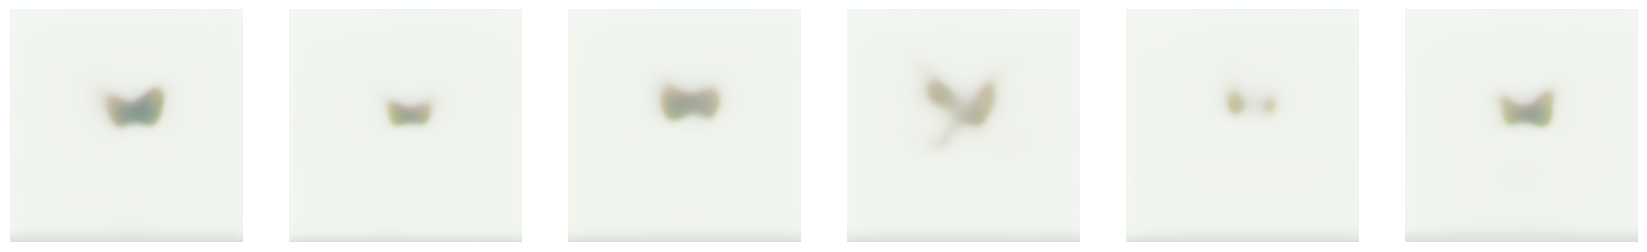

Step 400: g_loss 32.1975 critic_loss -33.5321 critic fake -30.2347  critic_real -3.2973 penalty 8.3574


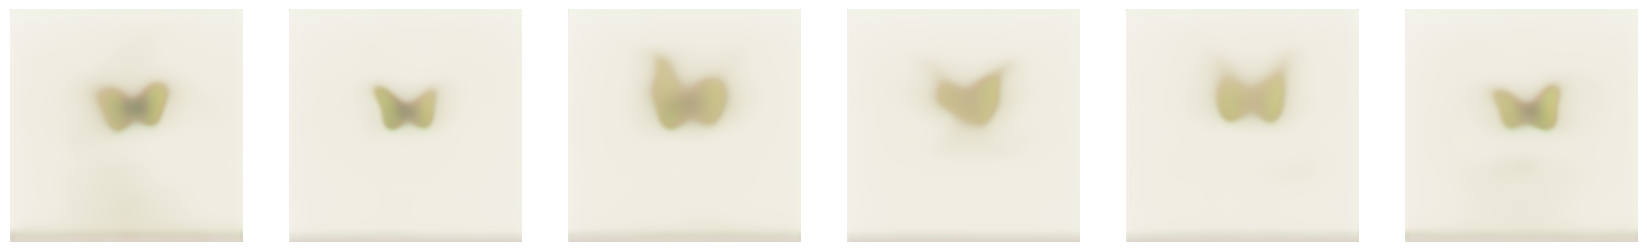

Step 500: g_loss 7.3295 critic_loss -27.2006 critic fake -5.5195  critic_real -21.6812 penalty 4.2868


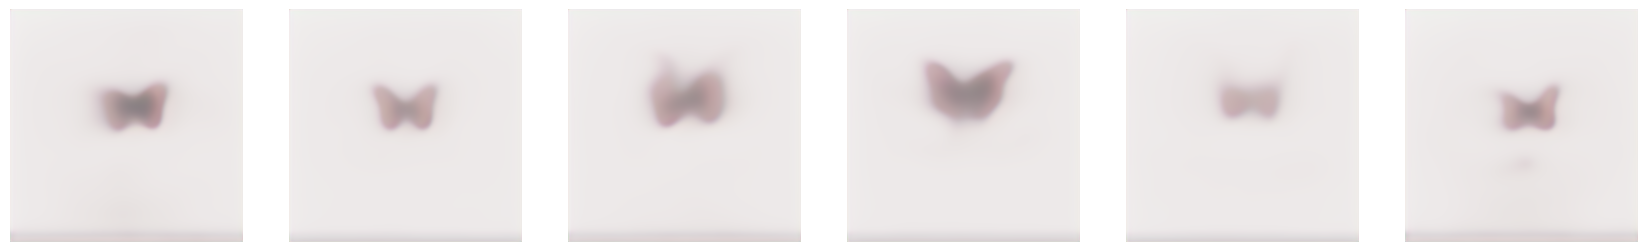

Step 600: g_loss -38.1012 critic_loss -30.9415 critic fake 24.0398  critic_real -54.9812 penalty 5.1991


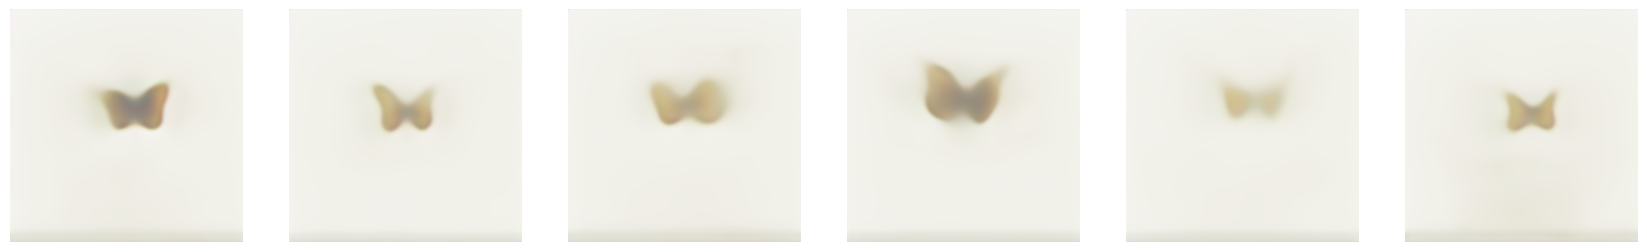

Step 700: g_loss 11.9248 critic_loss -31.1414 critic fake -10.4347  critic_real -20.7067 penalty 12.9241


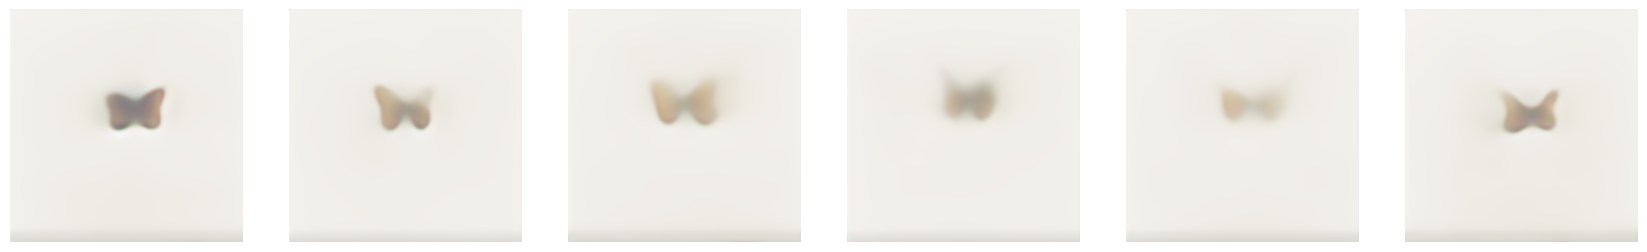

Step 800: g_loss 5.9210 critic_loss -32.6891 critic fake -3.8350  critic_real -28.8540 penalty 12.9986


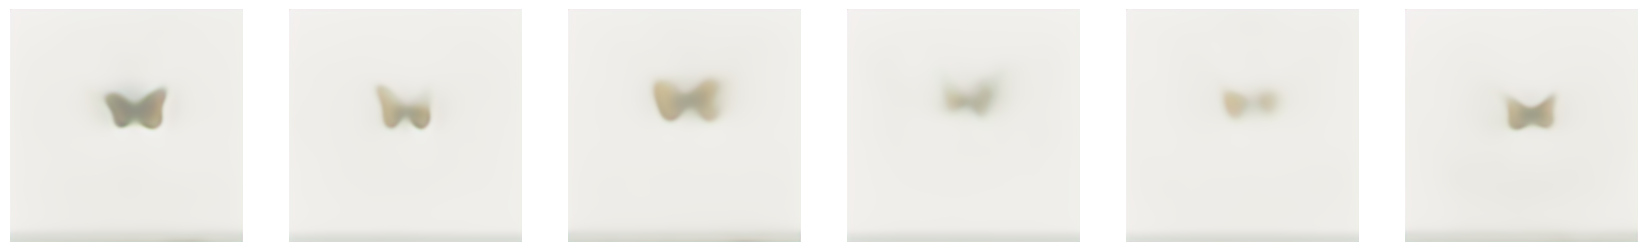

Step 900: g_loss -2.5152 critic_loss -31.0209 critic fake 1.0570  critic_real -32.0780 penalty 10.6821


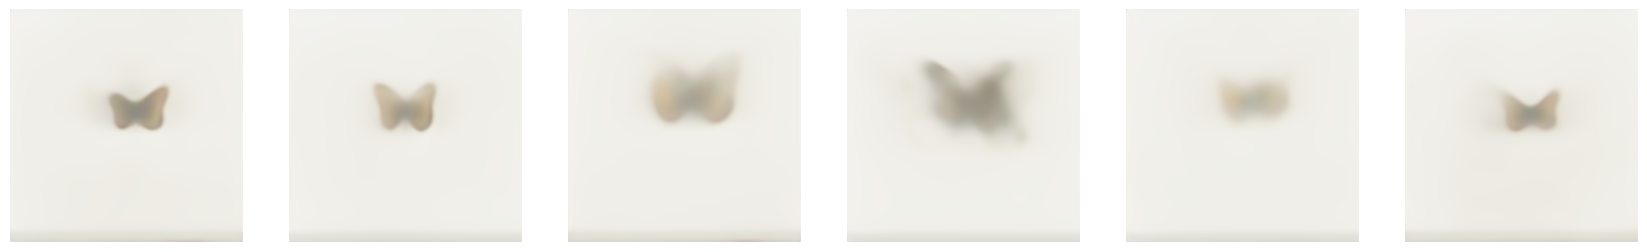

Step 1000: g_loss 8.1060 critic_loss -25.6865 critic fake -7.9436  critic_real -17.7429 penalty 6.4764


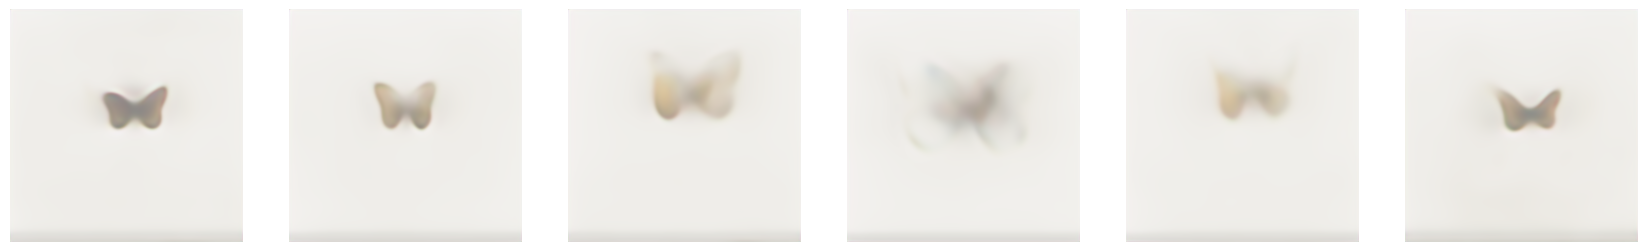

Step 1100: g_loss -1.2907 critic_loss -29.3384 critic fake 0.0789  critic_real -29.4173 penalty 2.2333


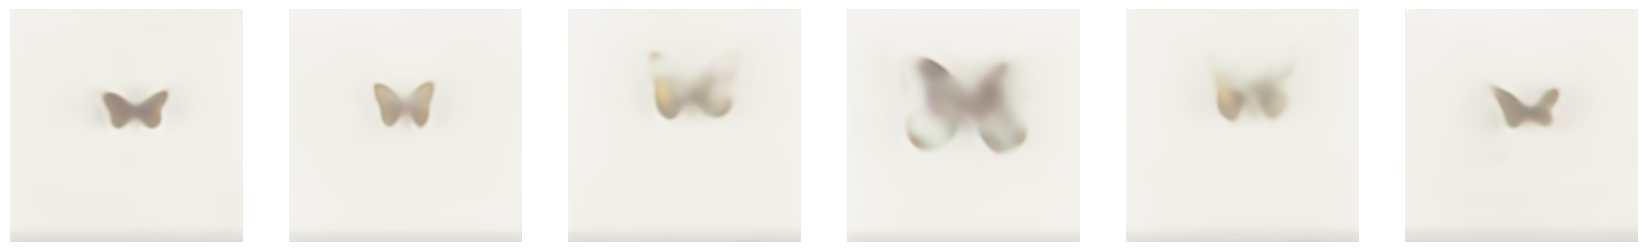

Step 1200: g_loss 5.4063 critic_loss -26.6760 critic fake -3.6277  critic_real -23.0484 penalty 3.9515


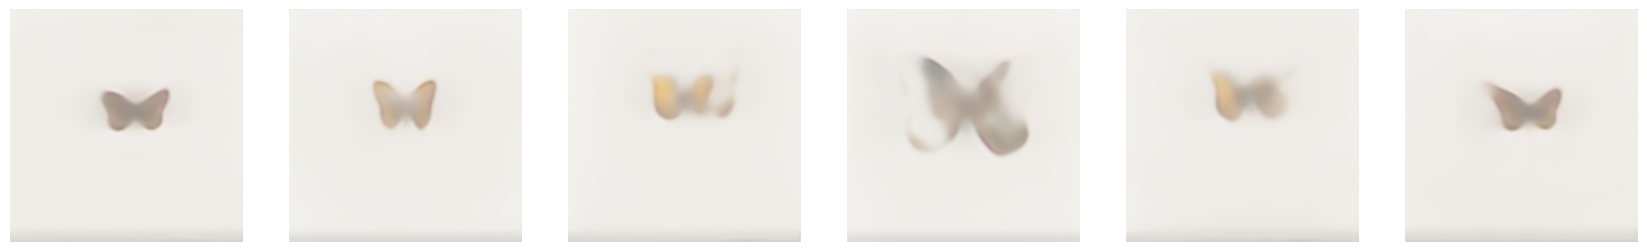

Step 1300: g_loss 3.6722 critic_loss -31.2659 critic fake 0.6999  critic_real -31.9657 penalty 10.6170


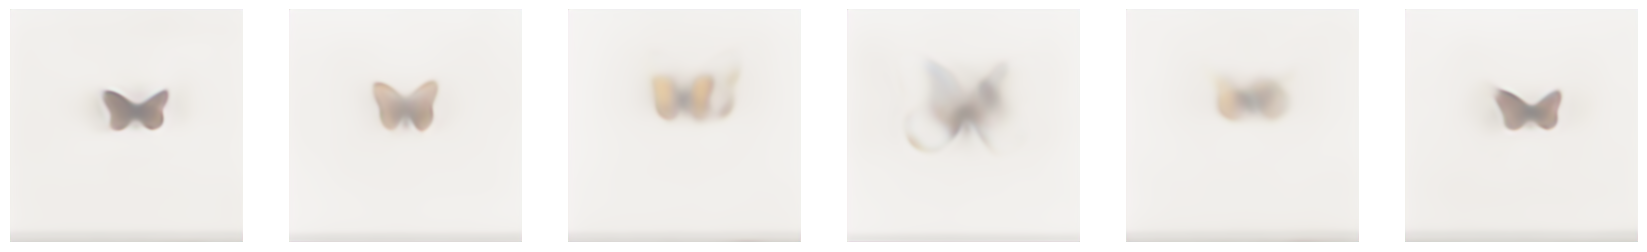

Step 1400: g_loss 1.7948 critic_loss -31.3826 critic fake -3.1786  critic_real -28.2040 penalty 11.2509


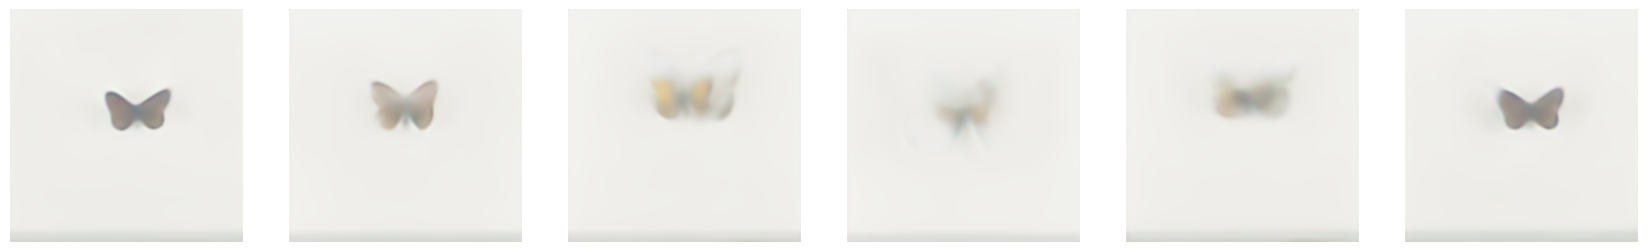

KeyboardInterrupt: 

In [14]:
wgan.train(image_batch, 16, 50000, 100)

Step 0: g_loss 220.3436 critic_loss -7.3999 critic fake -83.9204  critic_real 76.5206 penalty 0.1810


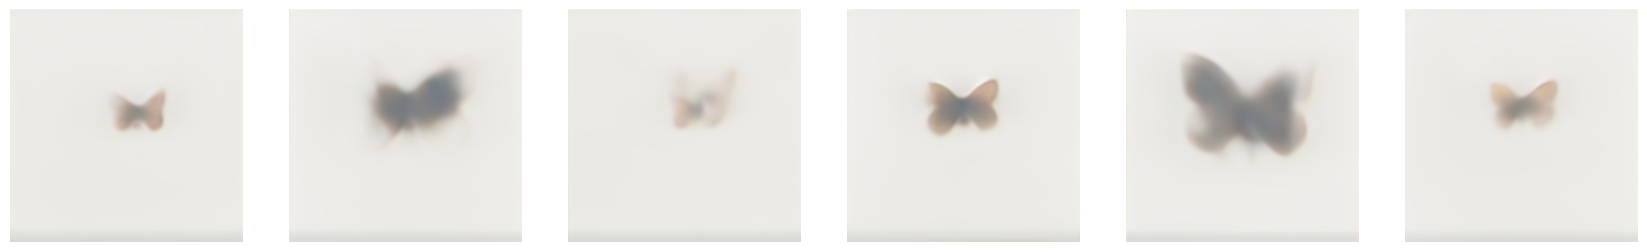

Step 100: g_loss -62.9125 critic_loss -17.7519 critic fake 31.1605  critic_real -48.9124 penalty 2.1272


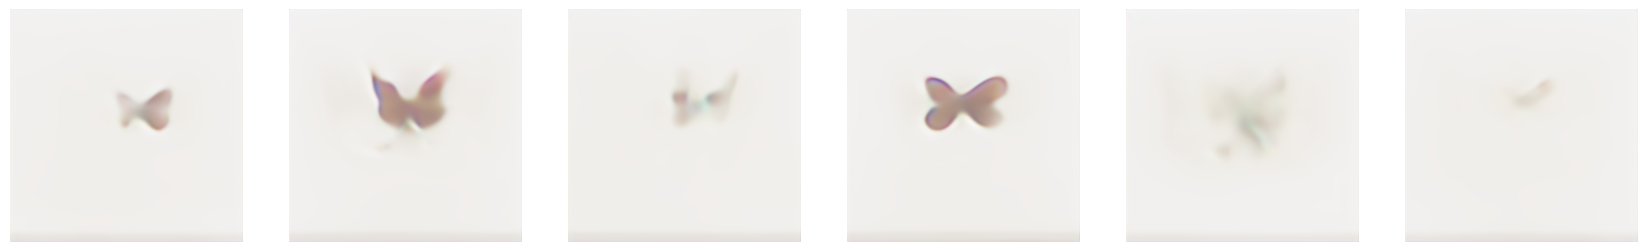

Step 200: g_loss -5.0253 critic_loss -24.9990 critic fake 11.1414  critic_real -36.1403 penalty 12.0702


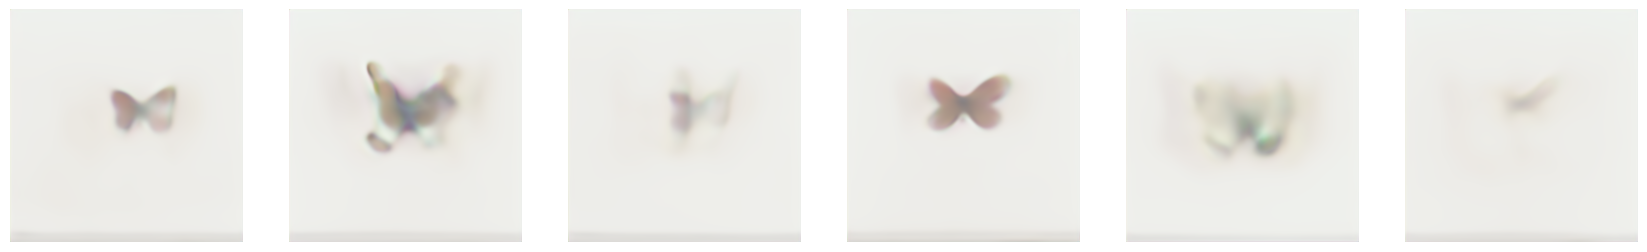

Step 300: g_loss 5.3850 critic_loss -21.4678 critic fake -1.8246  critic_real -19.6432 penalty 5.4820


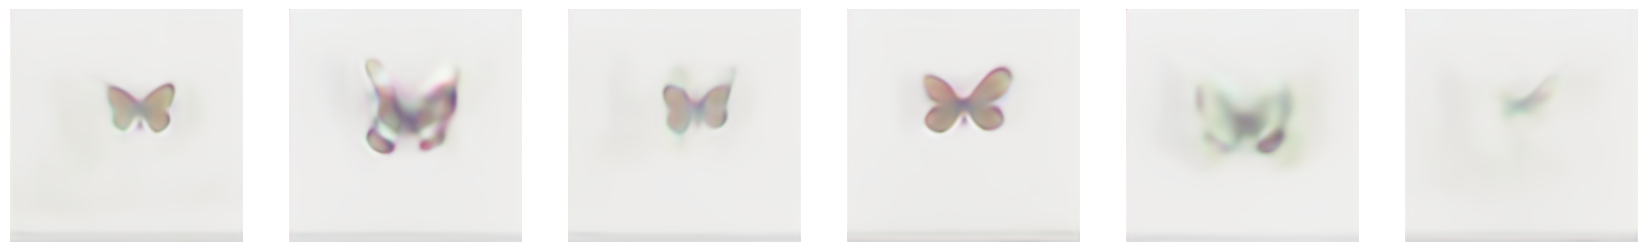

KeyboardInterrupt: 

In [15]:
wgan.train(image_batch, 16, 50000, 100)

In [ ]:
wgan.model.summary()

In [ ]:
wgan.generator.summary()

In [ ]:
wgan.critic.summary()

In [ ]:
z = tf.random.normal((8, 64))
generated_images = wgan.generator.predict(z)
wgan.plot_images(generated_images)

In [ ]:
for i in range(20):
    z = tf.random.normal((20, 64))
    images = wgan.generator.predict(z, verbose=0)
    
    grid_row = 1
    grid_col = 20
    f, axarr = plt.subplots(grid_row, grid_col, figsize=(grid_col*3.5, grid_row*3.5))
    for row in range(grid_row):
        for col in range(grid_col):
            axarr[col].imshow(images[col]*0.5+0.5)
            axarr[col].axis('off')
    plt.show()

In [20]:
wgan.generator.save_weights('wgan_gp_butterfly_512_.weights')

Load model and interpolate

In [11]:
wgan.generator.load_weights('wgan_gp_butterfly_512_.weights')

In [ ]:
z = tf.random.normal((6, 64))
generated_images = wgan.generator.predict(z)
wgan.plot_images(generated_images)

In [ ]:
for i in range(20):
    z = tf.random.normal((20, 64))
    images = wgan.generator.predict(z, verbose=0)
    
    grid_row = 1
    grid_col = 20
    f, axarr = plt.subplots(grid_row, grid_col, figsize=(grid_col*4, grid_row*4))
    for row in range(grid_row):
        for col in range(grid_col):
            axarr[col].imshow(images[col]*0.5+0.5)
            axarr[col].axis('off')
    plt.show()

In [23]:
def interpolate_points(p1, p2, n_steps=10):
# interpolate ratios between the points
    ratios = np.linspace(0, 1, num=n_steps)
# linear interpolate vectors
    vectors = list()
    for ratio in ratios:
        v = (1.0 - ratio) * p1 + ratio * p2
        vectors.append(v)
    return np.asarray(vectors)

In [24]:
def plot_generated(images, n):
    plt.figure(figsize=(100,100))
    for i in range(n):
        plt.subplot(1, n, 1+i)
        plt.axis('off')
        plt.imshow(images[i,:,:]*0.5+0.5)
    plt.show()

In [40]:
def save_generated(images, n, name):
    plt.figure(figsize=(100,100))
    for i in range(n):
        
        plt.axis('off')
        plt.imshow(images[i,:,:]*0.5+0.5)
        plt.savefig('./butterfly_512/image_{}_{}.jpg'.format(name, i))
    plt.show()

In [29]:
points = (np.random.randn(2*64)).reshape((2,64))

In [33]:
interpolated = interpolate_points(points[0], points[1],24)

In [34]:
images = wgan.generator.predict(tf.convert_to_tensor(interpolated))

1/1 [==============================] - 0s 14ms/step


In [ ]:
plot_generated(images, 24)

In [ ]:
save_generated(images, 1, 'first')